# Read Data from the Doppler Lidar and ingest into PyDDA

In [36]:
import glob
import utils
import xarray as xr
import pandas as pd
import numpy as np
import cmweather
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from datetime import datetime
import hvplot.xarray
from scipy.signal import convolve2d
import holoviews as hv
import pyart
from datatree import DataTree

## Compile a list of data files

In [37]:
files = sorted(glob.glob('/Users/rjackson/dl_cal_data/*.hpl'))

## Create helper functions to read in the data

In [66]:
def convert_to_hours_minutes_seconds(decimal_hour, initial_time):
    delta = timedelta(hours=decimal_hour)
    return datetime(initial_time.year, initial_time.month, initial_time.day) + delta

def read_as_netcdf(file, lat, lon, alt, scan_type='rhi', n_sweeps=1):
    field_dict = utils.hpl2dict(file)
    initial_time = pd.to_datetime(field_dict['start_time'])

    time = pd.to_datetime([convert_to_hours_minutes_seconds(x, initial_time) for x in field_dict['decimal_time']])

    ds = xr.Dataset(coords={'range':field_dict['center_of_gates'],
                            'time': time,
                            'azimuth': ('time', field_dict['azimuth']),
                            'elevation': ('time', field_dict['elevation'])} ,
                    data_vars={'radial_velocity':(['time', 'range'],
                                                  field_dict['radial_velocity'].T),
                               'beta': (('time', 'range'), 
                                        field_dict['beta'].T),
                               'intensity': (('time', 'range'),
                                             field_dict['intensity'].T)
                              }
                   )
    # Fake field for PYDDA
    ds['reflectivity'] = -99 * xr.ones_like(ds['beta'])
    ds['sweep_number'] = ('sweep', np.arange(0, n_sweeps))
    ds['sweep_number'].attrs["long_name"] = "sweep_index_number_0_based"
    ds['sweep_number'].attrs["units"] = ""
    ds['sweep_number'].attrs["_FillValue"] = -9999
    if scan_type.upper() == 'RHI':
        sweep_mode = 'rhi'
    elif scan_type.lower() == 'ppi':
        sweep_mode = "azimuth_surveillance"
    ds['sweep_mode'] = xr.DataArray(np.array([sweep_mode.lower()], dtype='S32'), dims=['sweep'])
    ds['azimuth'] = xr.where(ds['azimuth'] < 360., ds['azimuth'], ds['azimuth'] - 360.)
    if scan_type.upper() == 'RHI':
        ds['fixed_angle'] = ('fixed_angle', ds['azimuth'].data)
    elif scan_type.upper() == 'PPI':
        ds['fixed_angle'] = ('fixed_angle', np.unique(ds['elevation'].data))
    ds["latitude"] = lat
    ds["latitude"].attrs["long_name"] = 'latitude'
    ds["latitude"].attrs["units"] = "degrees_north"
    ds["latitude"].attrs["_FillValue"] = -9999.
    ds["longitude"] = lon
    ds["longitude"].attrs["long_name"] = 'longitude'
    ds["longitude"].attrs["units"] = "degrees_east"
    ds["longitude"].attrs["_FillValue"] = -9999.
    ds["altitude"] = alt
    ds["altitude"].attrs["long_name"] = alt
    ds["altitude"].attrs["units"] = "meters"
    ds["altitude"].attrs["_FillValue"] = -9999.
    num_rays = ds.dims['time']
    ds["sweep_start_ray_index"] = ('sweep', np.arange(0, num_rays, int(num_rays / n_sweeps)))
    ds["sweep_start_ray_index"].attrs["long_name"] = "index_of_first_ray_in_sweep"
    ds["sweep_start_ray_index"].attrs["units"] = ""
    ds["sweep_start_ray_index"].attrs["_FillValue"] = -9999
    ds["sweep_end_ray_index"] = ('sweep', np.arange(int(num_rays / n_sweeps), num_rays+1, int(num_rays / n_sweeps)))
    ds["sweep_end_ray_index"].attrs["long_name"] = "index_of_flast_ray_in_sweep"
    ds["sweep_end_ray_index"].attrs["units"] = ""
    ds["sweep_end_ray_index"].attrs["_FillValue"] = -9999
    ds.attrs["Conventions"] = "CF-1.7"
    ds.attrs["version"] = "CF-Radial-1.4"
    return ds

In [68]:
file = files[-1]
dataset = read_as_netcdf(file, 41.98053299237866, -87.71662374616044, 0., scan_type='ppi', n_sweeps=10)

ValueError: cannot reindex or align along dimension 'sweep' because of conflicting dimension sizes: {1, 10}

In [101]:
dataset['azimuth'].values

array([183.01, 186.01, 189.  , 192.01, 195.01, 198.  , 201.01, 204.01,
       207.  , 210.01, 213.01, 183.  , 186.01, 189.  , 192.01, 195.01,
       198.  , 201.01, 204.01, 207.  , 210.01, 213.01, 183.  , 186.01,
       189.  , 192.  , 195.01, 198.  , 201.  , 204.01, 207.01, 210.01,
       213.01, 183.  , 186.01, 189.  , 192.01, 195.01, 198.  , 201.  ,
       204.01, 207.  , 210.01, 213.  , 183.  , 186.  , 189.  , 192.01,
       195.01, 198.  , 201.01, 204.01, 207.  , 210.01, 213.  , 183.  ,
       186.01, 189.  , 192.01, 195.01, 198.  , 201.  , 204.01, 207.  ,
       210.01, 213.01, 183.  , 186.01, 189.  , 192.  , 195.01, 198.  ,
       201.01, 204.01, 207.  , 210.01, 213.01, 183.  , 186.01, 189.  ,
       192.01, 195.01, 198.  , 201.  , 204.01, 207.  , 210.01, 213.01,
       183.  , 186.01, 189.  , 192.  , 195.01, 198.  , 201.  , 204.01,
       207.  , 210.01, 213.01, 183.  , 186.01, 189.  , 192.01, 195.01,
       198.  , 201.01, 204.01, 207.  , 210.01, 213.  ])

## Read in the datasets and merge into a single dataset

(0.0, 400.0)

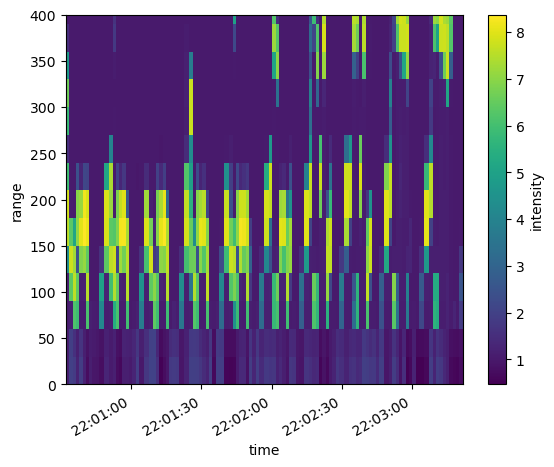

In [108]:
dataset['intensity'].T.plot()
plt.ylim([0, 400])

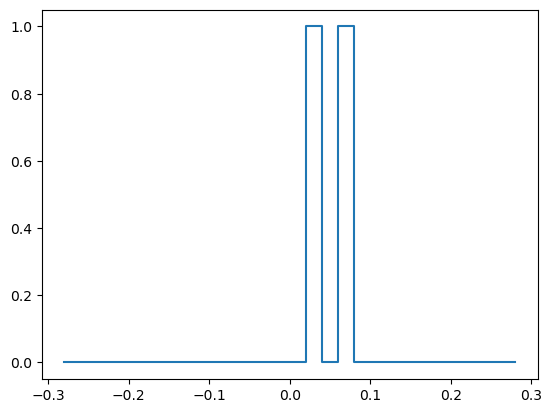

In [114]:
target_inds = np.argwhere(np.isclose(dataset['azimuth'], 201., atol=0.5))
hist, bins = np.histogram(dataset['radial_velocity'].values[target_inds, 5], bins=np.arange(-0.3, 0.3, 0.02))
plt.step(bins[1:], hist)

In [60]:
#dataset['radial_velocity'] = 8 * xr.ones_like(dataset['radial_velocity'])
dataset.to_netcdf('ncfile.nc')
radar = pyart.io.read_cfradial('ncfile.nc')
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	_FillValue: -9999.0
	long_name: 0.0
	units: meters
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (110,)>
	_FillValue: nan
elevation:
	data: <ndarray of type: float64 and shape: (110,)>
	_FillValue: nan
fields:
	radial_velocity:
		data: <ndarray of type: float64 and shape: (110, 400)>
		_FillValue: nan
		coordinates: azimuth elevation
	beta:
		data: <ndarray of type: float64 and shape: (110, 400)>
		_FillValue: nan
		coordinates: azimuth elevation
	intensity:
		data: <ndarray of type: float64 and shape: (110, 400)>
		_FillValue: nan
		coordinates: azimuth elevation
	reflectivity:
		data: <ndarray of type: float64 and shape: (110, 400)>
		_FillValue: nan
		coordinates: azimuth elevation
fixed_angle:
	data: <ndarray of type: float64 and shape: (10,)>
	_FillValue: nan
instrument_parameters: None
latitude:
	data: <ndarray of type: float64 and shape: (1,)>
	_FillValue: -9999.0
	lon

IndexError: ('Sweep out of range: ', 2)

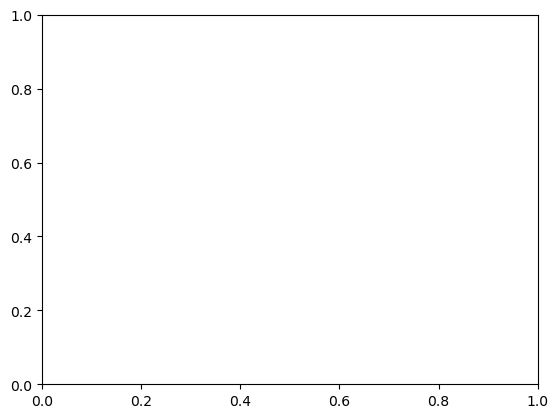

In [59]:
disp = pyart.graph.RadarDisplay(radar)
filter = pyart.filters.GateFilter(radar)
#filter.exclude_below('intensity', 1.02)
disp.plot_ppi('radial_velocity', sweep=2, cmap='balance', gatefilter=filter)
plt.xlim([-1, 1])
plt.ylim([0, 2])

In [326]:
grid_spec = (2, 100, 100)
grid_limits = ((0, 2000), (0, 2000.), (-0., 2000.))
grid = pyart.map.grid_from_radars([radar], grid_shape=grid_spec, grid_limits=grid_limits, fields=['radial_velocity', 'intensity'],
                                 gatefilter=filter, constant_roi=60., )
#grid.fields['radial_velocity']['data'] = np.ma.masked_where(grid.fields['intensity']['data'] < 1.02, grid.fields['radial_velocity']['data'])

/Users/rjackson/pyart/pyart/graph/gridmapdisplay.py:239: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Mercator.
  warnings.warn(


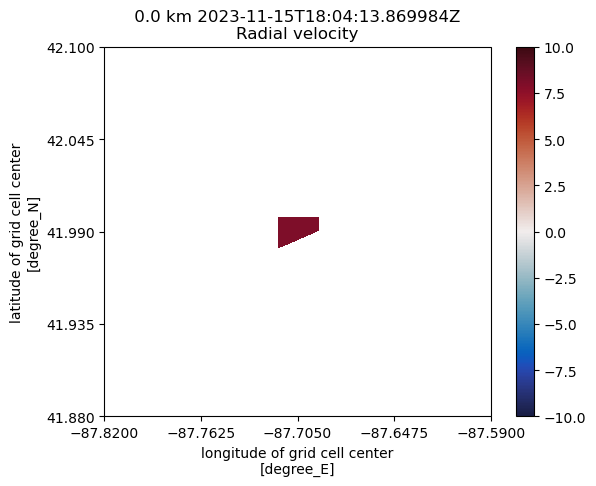

In [327]:
grid_disp = pyart.graph.GridMapDisplay(grid)
grid_disp.plot_grid('radial_velocity', 0, cmap='balance', vmin=-10, vmax=10)

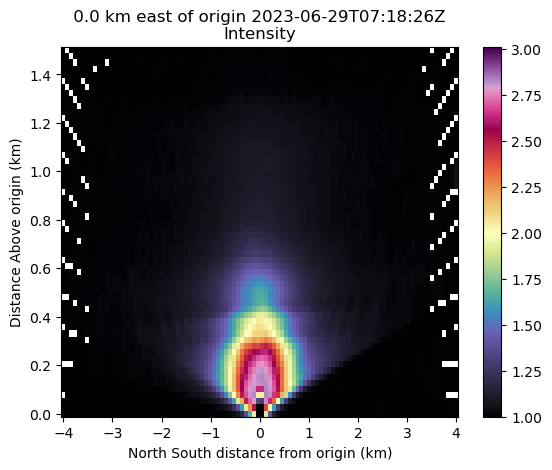

In [198]:
grid_disp = pyart.graph.GridMapDisplay(grid)
grid_disp.plot_longitudinal_level('intensity', 0, cmap='ChaseSpectral', vmin=1, vmax=3.01)

In [311]:
grid_pydda = pydda.io.read_from_pyart_grid(grid)

/Users/rjackson/PyDDA/pydda/retrieval/angles.py:25: RuntimeWarning: invalid value encountered in divide
  elev = np.arccos((Re**2 + slantrsq - rh**2) / (2 * Re * slantr))
/Users/rjackson/PyDDA/pydda/retrieval/angles.py:25: RuntimeWarning: invalid value encountered in arccos
  elev = np.arccos((Re**2 + slantrsq - rh**2) / (2 * Re * slantr))


In [228]:
grids[0]

<xarray.Dataset>
Dimensions:           (time: 1, z: 60, y: 100, x: 2, nradar: 1)
Coordinates:
  * time              (time) object 2023-06-29 07:18:26.129987
  * z                 (z) float64 0.0 25.42 50.85 ... 1.475e+03 1.5e+03
    lat               (y, x) float64 41.94 41.94 41.95 ... 42.02 42.02 42.02
    lon               (y, x) float64 -87.72 -87.72 -87.72 ... -87.72 -87.72
  * y                 (y) float64 -4e+03 -3.919e+03 ... 3.919e+03 4e+03
  * x                 (x) float64 0.0 100.0
Dimensions without coordinates: nradar
Data variables: (12/22)
    radial_velocity   (time, z, y, x) float64 nan nan nan nan ... nan nan nan
    intensity         (time, z, y, x) float64 0.9999 nan 1.0 ... nan 1.006 nan
    ROI               (time, z, y, x) float32 60.0 60.0 60.0 ... 60.0 60.0 60.0
    projection        int64 1
    radar_latitude    (nradar) float64 41.98
    radar_longitude   (nradar) float64 -87.72
    ...                ...
    AZ                (time, z, y, x) float64 180.0 178.6 180.0 ... 0.0 1.432
    EL                (time, z, y, x) float64 -0.01349 -0.01349 ... 20.54 20.53
    u                 (time, z, y, x) float64 43.88 43.88 ... -71.66 -71.66
    v                 (time, z, y, x) float64 9.967 1.505e-15 ... -2.354e-20
    w                 (time, z, y, x) float64 nan nan nan nan ... nan nan nan
    reflectivity      (time, z, y, x) float64 -999.0 -999.0 ... -999.0 -999.0
Attributes:
    first_grid_name:  radial_velocity
    units:            m
    long_name:        Point altitude

In [334]:
grid_pydda = pydda.initialization.make_constant_wind_field(grid_pydda, (0., 0., 0.))
grid_pydda['reflectivity'] = -999 * xr.ones_like(grid_pydda['intensity'])
grids, _ = pydda.retrieval.get_dd_wind_field([grid_pydda], Co=1,  wind_tol=0.10, vel_name='radial_velocity', low_pass_filter=False)

False
Starting solver 
rmsVR = 8.0
Total points: 7417
The max of w_init is 0.0
Total number of model points: 0
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
      0|7417.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000
The gradient of the cost functions is 77.43228062959608
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     10|1501.4297|1605.9903|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000
The gradient of the cost functions is 67.71547035119507
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     20|  77.8251|2343.4361|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000
The gradient of the cost functions is 83.16957497820778
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     30| 145.4362|1726.3472|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000
The gradient of the c

<Axes: title={'center': 'PyDDA retreived winds @0.0 km'}, xlabel='X [km]', ylabel='Y [km]'>

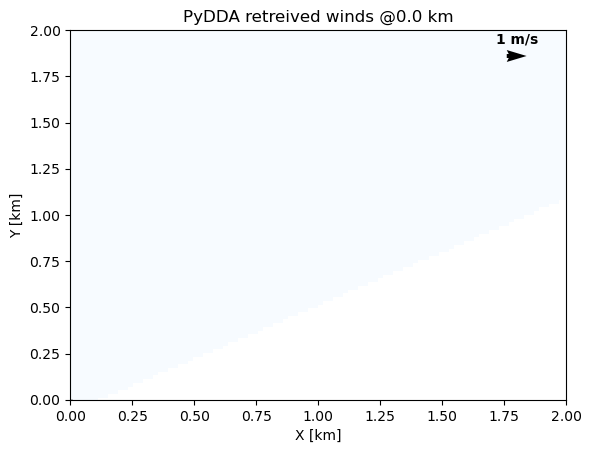

In [329]:
pydda.vis.plot_horiz_xsection_quiver(grids, colorbar_flag=False, level=0, background_field='intensity',cmap='Blues', quiverkey_len=1, vmin=0, vmax=0)

ValueError: too many values to unpack (expected 2)

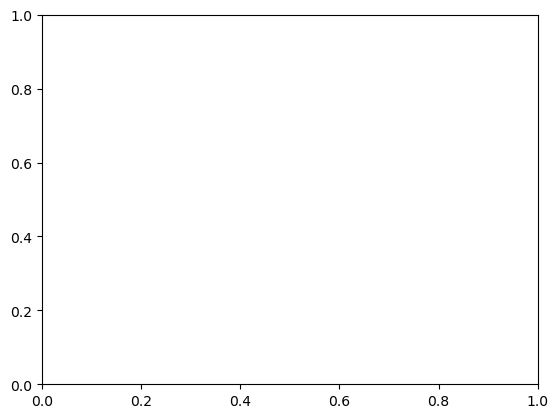

In [335]:
x = grids[0]['point_x'].values[0, :, :]
y = grids[0]['point_y'].values[0, :, :]
u = grids[0]['u'].values[0, :, :]
v = grids[0]['v'].values[0, :, :]
plt.quiver(x, y, u, v)

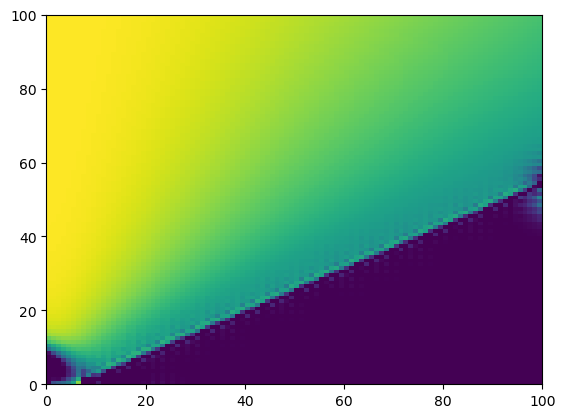

In [337]:
plt.pcolormesh(v[0], vmin=0, vmax=8)

In [164]:
from datetime import timedelta

In [166]:
initial_time + timedelta(hours=72.345)

Timestamp('2022-12-11 15:26:30.230000')

In [170]:
pd.to_datetime("%d:%02d.%02.6f" % (hours, minutes, seconds))

NameError: name 'hours' is not defined

In [171]:
"%02.6f" % 7.329996000000392

'7.329996'

In [172]:
pd.to_datetime(['2022-12-08 15:05.47'])

DatetimeIndex(['2022-12-08 15:05:28'], dtype='datetime64[ns]', freq=None)

In [175]:
time

DatetimeIndex(['2022-12-08 15:05:47.699988', '2022-12-08 15:05:49.340004',
               '2022-12-08 15:05:50.970012', '2022-12-08 15:05:52.609992',
               '2022-12-08 15:05:54.250008', '2022-12-08 15:05:55.880016',
               '2022-12-08 15:05:57.519996', '2022-12-08 15:05:59.150004',
               '2022-12-08 15:06:00.780012', '2022-12-08 15:06:02.419992',
               '2022-12-08 15:06:04.060008', '2022-12-08 15:06:05.690016',
               '2022-12-08 15:06:07.329996'],
              dtype='datetime64[ns]', freq=None)

In [35]:
field_dict['spectral_width'].shape

(133, 13)

In [36]:
field_dict['center_of_gates'].shape

(133,)

In [191]:
field_dict

{'filename': 'RHI_240_20221208_150544.hpl',
 'system_id': 240,
 'number_of_gates': 133,
 'range_gate_length_m': 24.0,
 'gate_length_pts': 8,
 'pulses_per_ray': 5000,
 'number_of_waypoints_in_file': 13,
 'no_of_rays_in_file': 13,
 'scan_type': 'RHI',
 'focus_range': '65535',
 'start_time': '20221208 15:05:48.23',
 'resolution': '0.0382 m s-1',
 'range_gates': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113

In [8]:
utils.hpl_to_netcdf(files[0], 'sample_file.nc')

sample_file.nc/2022/202212/20221208/RHI_240_20221208_150544_l0.nc is created succesfully
